In [1]:
!pip install pandas geopandas matplotlib faker pyspark pyarrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 1.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 2.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 4.6 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 4.4 MB/s eta 0:00:0000:0100:01
--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/utils/logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/console.py", line 1752, in print
    extend(render(renderable, render_options))
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/console.py", line 1390, in render
    for render_output in iter_render:
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/utils/logging.py", line 134, in __rich_console__
    for line in lines

In [2]:
#### Capa bronze data cruda
####
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_json, col
from pyspark.sql.types import StructType, StringType, DoubleType, IntegerType, TimestampType

# Crear sesión de Spark
spark = SparkSession \
    .builder \
    .appName("SparkStreamingFromSocket") \
    .master("local[*]") \
    .config("spark.executor.memory", "4g") \
    .config("spark.executor.cores", "4") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "4") \
    .getOrCreate()

# Definir el esquema para los datos JSON que se recibirán
schema = StructType() \
    .add("latitude", DoubleType()) \
    .add("longitude", DoubleType()) \
    .add("date", TimestampType()) \
    .add("customer_id", StringType()) \
    .add("employee_id", StringType()) \
    .add("quantity_products", IntegerType()) \
    .add("order_id", StringType()) \
    .add("commune_code", StringType()) \
    .add("commune_name", StringType()) \
    .add("customer_name", StringType()) \
    .add("employee_name", StringType()) \
    .add("employee_commission", DoubleType())

# Leer datos desde el socket
streaming_df = spark \
    .readStream \
    .format("socket") \
    .option("host", "localhost") \
    .option("port", 12345) \
    .load()

# Parsear los datos JSON utilizando el esquema definido
parsed_df = streaming_df \
    .select(from_json(col("value").cast("string"), schema).alias("parsed_value")) \
    .select("parsed_value.*")

# Función para guardar los datos recibidos en bronze
def process_data(df, epoch_id):
    try:
        hdfs_path = "/user/root/bronze"
        df.write \
          .format("parquet") \
          .mode("append") \
          .save(hdfs_path)
        df.show(truncate=False)
    except Exception as e:
        print(f"Error al procesar los datos: {e}")
        
# Escribir los resultados en la consola
query = parsed_df \
    .writeStream \
    .foreachBatch(process_data) \
    .outputMode("append") \
    .start()

# Mantener el stream en ejecución
query.awaitTermination()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


+--------+---------+----+-----------+-----------+-----------------+--------+------------+------------+-------------+-------------+-------------------+
|latitude|longitude|date|customer_id|employee_id|quantity_products|order_id|commune_code|commune_name|customer_name|employee_name|employee_commission|
+--------+---------+----+-----------+-----------+-----------------+--------+------------+------------+-------------+-------------+-------------------+
+--------+---------+----+-----------+-----------+-----------------+--------+------------+------------+-------------+-------------+-------------------+



+-----------------+------------------+-------------------+-----------+-----------+-----------------+----------+------------+-------------------------------------+----------------+-----------------+-------------------+
|latitude         |longitude         |date               |customer_id|employee_id|quantity_products|order_id  |commune_code|commune_name                         |customer_name   |employee_name    |employee_commission|
+-----------------+------------------+-------------------+-----------+-----------+-----------------+----------+------------+-------------------------------------+----------------+-----------------+-------------------+
|6.196502910351415|-75.49101140917254|2023-08-30 15:34:07|7169       |6696       |62               |5341885103|90          |CORREGIMIENTO DE SANTA ELENA         |John Austin     |Patricia Cox     |0.04               |
|6.248113021782335|-75.63517821594705|2023-07-01 20:20:53|6443       |9726       |50               |9978615689|70          |CORR

+-----------------+------------------+-------------------+-----------+-----------+-----------------+----------+------------+------------------------------+---------------+-----------------+-------------------+
|latitude         |longitude         |date               |customer_id|employee_id|quantity_products|order_id  |commune_code|commune_name                  |customer_name  |employee_name    |employee_commission|
+-----------------+------------------+-------------------+-----------+-----------+-----------------+----------+------------+------------------------------+---------------+-----------------+-------------------+
|6.277654836767925|-75.5014680169393 |2023-09-02 15:49:55|8156       |1114       |71               |2549371631|90          |CORREGIMIENTO DE SANTA ELENA  |Connor Wells   |Bevis Sanford    |0.14               |
|6.290160380888477|-75.50937232259703|2023-01-20 17:41:47|2553       |4750       |53               |4338289470|90          |CORREGIMIENTO DE SANTA ELENA  |Bo Jo

KeyboardInterrupt: 

+------------------+------------------+-------------------+-----------+-----------+-----------------+----------+------------+------------------------------------------+-----------------+---------------+-------------------+
|latitude          |longitude         |date               |customer_id|employee_id|quantity_products|order_id  |commune_code|commune_name                              |customer_name    |employee_name  |employee_commission|
+------------------+------------------+-------------------+-----------+-----------+-----------------+----------+------------+------------------------------------------+-----------------+---------------+-------------------+
|6.177133782510081 |-75.63942605276155|2023-11-29 21:29:14|3877       |2232       |47               |5888175604|80          |CORREGIMIENTO DE SAN ANTONIO DE PRADO     |Imogene Blanchard|Forrest Bradley|0.07               |
|6.177088921816965 |-75.67008825983528|2023-05-04 06:19:48|1923       |1473       |82               |7181195

+-----------------+------------------+-------------------+-----------+-----------+-----------------+----------+------------+------------------------------------------+---------------+---------------+-------------------+
|latitude         |longitude         |date               |customer_id|employee_id|quantity_products|order_id  |commune_code|commune_name                              |customer_name  |employee_name  |employee_commission|
+-----------------+------------------+-------------------+-----------+-----------+-----------------+----------+------------+------------------------------------------+---------------+---------------+-------------------+
|6.337373992032482|-75.6549011574731 |2023-05-25 04:43:28|6624       |1737       |40               |7540874666|50          |CORREGIMIENTO DE SAN SEBASTIÁN DE PALMITAS|Jamal Morgan   |Althea Mckenzie|0.13               |
|6.28432360444997 |-75.52552925957863|2023-07-14 18:08:06|3522       |5668       |93               |4633972290|90       

+-----------------+------------------+-------------------+-----------+-----------+-----------------+----------+------------+-------------------------------------+----------------+-------------+-------------------+
|latitude         |longitude         |date               |customer_id|employee_id|quantity_products|order_id  |commune_code|commune_name                         |customer_name   |employee_name|employee_commission|
+-----------------+------------------+-------------------+-----------+-----------+-----------------+----------+------------+-------------------------------------+----------------+-------------+-------------------+
|6.180126306184711|-75.5510342843638 |2023-04-05 15:26:53|5395       |6659       |90               |3877395121|90          |CORREGIMIENTO DE SANTA ELENA         |Davis Rivera    |Melinda Le   |0.06               |
|6.275065380506148|-75.57496977190979|2023-11-18 20:14:55|2008       |2470       |88               |562864457 |05          |CASTILLA            

+------------------+------------------+-------------------+-----------+-----------+-----------------+----------+------------+------------------------------------------+---------------+-------------+-------------------+
|latitude          |longitude         |date               |customer_id|employee_id|quantity_products|order_id  |commune_code|commune_name                              |customer_name  |employee_name|employee_commission|
+------------------+------------------+-------------------+-----------+-----------+-----------------+----------+------------+------------------------------------------+---------------+-------------+-------------------+
|6.275757620584878 |-75.67591776116971|2023-07-31 14:15:11|9784       |4942       |25               |1622167263|60          |CORREGIMIENTO DE SAN CRISTÓBAL            |Tiger Kline    |Sydnee Kirby |0.16               |
|6.362414432618344 |-75.67423424081302|2023-06-19 03:47:40|6253       |6659       |95               |3288938066|50          

+-----------------+------------------+-------------------+-----------+-----------+-----------------+----------+------------+------------------------------------------+-----------------+---------------+-------------------+
|latitude         |longitude         |date               |customer_id|employee_id|quantity_products|order_id  |commune_code|commune_name                              |customer_name    |employee_name  |employee_commission|
+-----------------+------------------+-------------------+-----------+-----------+-----------------+----------+------------+------------------------------------------+-----------------+---------------+-------------------+
|6.256326231393246|-75.63818501696889|2023-06-15 05:13:40|6255       |5668       |79               |8910497362|60          |CORREGIMIENTO DE SAN CRISTÓBAL            |Jesse Lucas      |Melanie Ball   |0.18               |
|6.314370738611778|-75.63938616589952|2024-02-28 22:33:12|2381       |1482       |77               |2010904939|6

+-----------------+------------------+-------------------+-----------+-----------+-----------------+----------+------------+-------------------------------------+--------------+----------------+-------------------+
|latitude         |longitude         |date               |customer_id|employee_id|quantity_products|order_id  |commune_code|commune_name                         |customer_name |employee_name   |employee_commission|
+-----------------+------------------+-------------------+-----------+-----------+-----------------+----------+------------+-------------------------------------+--------------+----------------+-------------------+
|6.208520858349714|-75.561918482356  |2024-02-09 10:03:34|3746       |3830       |34               |2089970943|14          |EL POBLADO                           |Tiger Booker  |Shaeleigh Turner|0.06               |
|6.215838571555092|-75.68563234401788|2023-02-22 00:34:58|2194       |1482       |48               |4512280063|80          |CORREGIMIENTO DE

In [3]:
#### Capa silver procesamiento
####
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql.functions import col, expr, round, lit, year, month, dayofmonth, trim, hour, minute, second, dayofweek
import os 

# Obtener la sesión de Spark existente si está activa
spark = SparkSession.builder.getOrCreate()

# Función para leer archivos Parquet desde HDFS
def leer_archivos_parquet(path: str) -> DataFrame:
    try:
        # Verificar la existencia del archivo antes de leerlo
        if os.system(f"hdfs dfs -test -e {path}") == 0:
            return spark.read.parquet(path)
        else:
            print(f"El archivo Parquet {path} no existe.")
            return None
    except Exception as e:
        print(f"Error al leer el archivo Parquet {path}: {e}")
        return None
    
# Ruta de bronze
bronze_path = "hdfs:///user/root/bronze"  

# Leer archivos Parquet desde el directorio en HDFS
df_bronze = leer_archivos_parquet(bronze_path)

# Función para agregar una columna con valor constante al precio y dividir la fecha
def transformar_df(df: DataFrame) -> DataFrame:
        df_transformado = df \
            .withColumn("price", lit(3500)) \
            .withColumn("sales", col("quantity_products") * col("price")) \
            .withColumn("commission_value", round(col("sales") * col("employee_commission"), 0)) \
            .withColumn("customer_name", trim(col("customer_name"))) \
            .withColumn("employee_name", trim(col("employee_name"))) \
            .withColumn("commune_name", trim(col("commune_name"))) \
            .withColumn("year", year(col("date"))) \
            .withColumn("month", month(col("date"))) \
            .withColumn("day", dayofmonth(col("date"))) \
            .withColumn("day_week", dayofweek(col("date"))) \
            .withColumn("hour", hour(col("date"))) \
            .withColumn("minute", minute(col("date"))) \
            .withColumn("second", second(col("date")))
        return df_transformado

# Función para guardar DataFrame en un archivo Parquet en la capa Silver, siempre sobreescribe esto es compactar
def guardar_archivo_parquet(df: DataFrame, path: str) -> None:
    df.coalesce(1).write \
        .mode("overwrite") \
        .parquet(path)
        
# Función principal para unir archivos de Bronze a Silver
def unir_archivos_bronze_a_silver(bronze_path: str, silver_path: str) -> None:
    # Leer archivos Parquet desde la capa Bronze
    df_bronze = leer_archivos_parquet(bronze_path)

    # Transformar el DataFrame de Bronze
    df_transformado = transformar_df(df_bronze)

    # Guardar el DataFrame transformado en la capa Silver
    guardar_archivo_parquet(df_transformado, silver_path)

    # Leer archivos Parquet desde la capa Silver después de transformar
    df_silver_transformado = leer_archivos_parquet(silver_path)

    if df_silver_transformado is not None:
        # Contar la cantidad de registros en la capa Silver después de transformar
        records_processed = df_silver_transformado.count()
        print(f"Cantidad de registros procesados en silver después de transformar: {records_processed}")
    
    # Mostrar el DataFrame transformado (opcional)
    df_transformado.printSchema()
    df_transformado.show()

# Rutas en hdfs (distrbuido)
bronze_path = "hdfs:///user/root/bronze"  
silver_path = "hdfs:///user/root/silver/unificado.parquet"  

# Ejecutar el proceso de unión
unir_archivos_bronze_a_silver(bronze_path, silver_path)


+-----------------+------------------+-------------------+-----------+-----------+-----------------+----------+------------+------------------------------------------+---------------+-----------------+-------------------+
|latitude         |longitude         |date               |customer_id|employee_id|quantity_products|order_id  |commune_code|commune_name                              |customer_name  |employee_name    |employee_commission|
+-----------------+------------------+-------------------+-----------+-----------+-----------------+----------+------------+------------------------------------------+---------------+-----------------+-------------------+
|6.279293008698208|-75.63297212211366|2023-06-26 01:36:11|9094       |1114       |23               |2545032105|60          |CORREGIMIENTO DE SAN CRISTÓBAL            |Ava Acevedo    |Bevis Sanford    |0.14               |
|6.236238275319467|-75.65118534260966|2023-05-30 14:51:43|4922       |6659       |52               |6301295023|7

Cantidad de registros procesados en silver después de transformar: 80
root
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- employee_id: string (nullable = true)
 |-- quantity_products: integer (nullable = true)
 |-- order_id: string (nullable = true)
 |-- commune_code: string (nullable = true)
 |-- commune_name: string (nullable = true)
 |-- customer_name: string (nullable = true)
 |-- employee_name: string (nullable = true)
 |-- employee_commission: double (nullable = true)
 |-- price: integer (nullable = false)
 |-- sales: integer (nullable = true)
 |-- commission_value: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- day_week: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)
 |-- second: integer (nullable = true)



+-----------------+------------------+-------------------+-----------+-----------+-----------------+----------+------------+--------------------+----------------+-----------------+-------------------+-----+------+----------------+----+-----+---+--------+----+------+------+
|         latitude|         longitude|               date|customer_id|employee_id|quantity_products|  order_id|commune_code|        commune_name|   customer_name|    employee_name|employee_commission|price| sales|commission_value|year|month|day|day_week|hour|minute|second|
+-----------------+------------------+-------------------+-----------+-----------+-----------------+----------+------------+--------------------+----------------+-----------------+-------------------+-----+------+----------------+----+-----+---+--------+----+------+------+
|6.339593605215196|-75.66588800400496|2023-03-07 19:52:57|       3157|       1473|               57|6005799972|          50|CORREGIMIENTO DE ...|  Brendan Valdez|    Celeste John

+-----------------+------------------+-------------------+-----------+-----------+-----------------+----------+------------+-------------------------------------+---------------+-----------------+-------------------+
|latitude         |longitude         |date               |customer_id|employee_id|quantity_products|order_id  |commune_code|commune_name                         |customer_name  |employee_name    |employee_commission|
+-----------------+------------------+-------------------+-----------+-----------+-----------------+----------+------------+-------------------------------------+---------------+-----------------+-------------------+
|6.300493833361968|-75.64355301613097|2024-02-11 13:06:58|8468       |1473       |89               |1618729983|60          |CORREGIMIENTO DE SAN CRISTÓBAL       |Griffith Bruce |Celeste Johns    |0.07               |
|6.27110183751378 |-75.60475981582623|2023-12-02 06:12:38|7812       |6337       |76               |3539376829|60          |CORREGIM

+------------------+------------------+-------------------+-----------+-----------+-----------------+----------+------------+------------------------------------------+------------------+-----------------+-------------------+
|latitude          |longitude         |date               |customer_id|employee_id|quantity_products|order_id  |commune_code|commune_name                              |customer_name     |employee_name    |employee_commission|
+------------------+------------------+-------------------+-----------+-----------+-----------------+----------+------------+------------------------------------------+------------------+-----------------+-------------------+
|6.238296664396859 |-75.49752441264042|2024-04-13 13:33:47|1488       |9726       |20               |3630606813|90          |CORREGIMIENTO DE SANTA ELENA              |Mark Peterson     |Christen Hamilton|0.17               |
|6.366344401232285 |-75.69112451827023|2023-08-12 02:24:52|5041       |3455       |58           

+-----------------+------------------+-------------------+-----------+-----------+-----------------+----------+------------+------------------------------------------+----------------+----------------+-------------------+
|latitude         |longitude         |date               |customer_id|employee_id|quantity_products|order_id  |commune_code|commune_name                              |customer_name   |employee_name   |employee_commission|
+-----------------+------------------+-------------------+-----------+-----------+-----------------+----------+------------+------------------------------------------+----------------+----------------+-------------------+
|6.203362777871641|-75.618557002725  |2023-03-09 03:50:07|9528       |6659       |38               |2559882699|70          |CORREGIMIENTO DE ALTAVISTA                |Felix Allison   |Melinda Le      |0.06               |
|6.223260539815256|-75.62651798363864|2023-08-27 00:06:03|6569       |3830       |81               |7935169876|7

In [5]:
#### Capa gold
####
from pyspark.sql import SparkSession 
from pyspark.sql.functions import sum, max, min, avg, count, col

# Obtener la sesión de Spark existente si está activa
spark = SparkSession.builder.getOrCreate()

# Ruta del archivo Parquet en la capa Silver
silver_path = "hdfs:///user/root/silver/unificado.parquet"

# Leer los datos desde el archivo Parquet en la capa Silver
df = spark.read.parquet(silver_path)

# Crear la base de datos si no existe
spark.sql("CREATE DATABASE IF NOT EXISTS UNALwater")

# Establecer la base de datos en uso
spark.sql("USE UNALwater")

# Definir la ruta en HDFS donde se guardará la tabla en formato Parquet en la capa Gold
gold_path = "hdfs:///user/root/gold/UNALWater"

# Insertar el dataframe en una tabla externa UNALWater particionada por el campo 'date'
df.write.mode("append") \
  .partitionBy("date") \
  .format("parquet") \
  .option("path", gold_path) \
  .saveAsTable("UNALWater")

# Mostrar la estructura de la tabla
print("Estructura de la tabla UNALWater:")
spark.sql("DESCRIBE UNALWater").show()

# Construir y ejecutar consultas SQL para responder preguntas de negocio
query_ventas_por_comuna = """
    SELECT 
        CASE 
            WHEN commune_name LIKE '%CORREGIMIENTO DE SAN SEBAS%' THEN 'SAN SEBASTIAN DE PALMITAS'
            WHEN commune_name LIKE '%CORREGIMIENTO DE SAN CRIS%' THEN 'SAN CRISTOBAL'
            WHEN commune_name = 'CORREGIMIENTO DE ALTAVISTA' THEN 'ALTAVISTA'
            WHEN commune_name = 'CORREGIMIENTO DE SANTA ELENA' THEN 'SANTA ELENA'
            WHEN commune_name = 'CORREGIMIENTO DE SAN ANTONIO DE PRADO' THEN 'SAN ANTONIO DE PRADO'
        ELSE commune_name END AS Comuna_Corregimiento,
        SUM(quantity_products) AS Cantidad_Productos,
        SUM(sales) AS Total_Ventas
    FROM UNALWater
    GROUP BY Comuna_Corregimiento
    ORDER BY Total_Ventas DESC;
"""

query_ventas_por_vendedor = """
    SELECT 
        employee_name AS Vendedor,
        SUM(quantity_products) AS Cantidad_Productos,
        SUM(sales) AS Total_Ventas,
        SUM(commission_value) AS Valor_Comision
    FROM UNALWater
    GROUP BY employee_name
    ORDER BY Valor_Comision DESC
"""

query_top10_por_clientes = """
    SELECT 
        customer_name AS Cliente,
        SUM(quantity_products) AS Cantidad_Productos,
        SUM(sales) AS Total_Ventas
    FROM UNALWater
    GROUP BY customer_name
    ORDER BY Total_Ventas DESC
    LIMIT 10
"""

query_ventas_por_dia = """
    SELECT 
        CASE 
            WHEN day_week = 1 THEN 'Domingo' 
            WHEN day_week = 2 THEN 'Lunes' 
            WHEN day_week = 3 THEN 'Martes'
            WHEN day_week = 4 THEN 'Miércoles'
            WHEN day_week = 5 THEN 'Jueves'
            WHEN day_week = 6 THEN 'Viernes'
            WHEN day_week = 7 THEN 'Sábado'
        END AS Dia_Semana,
        SUM(quantity_products) AS Cantidad_Productos,
        SUM(sales) AS Total_Ventas
    FROM UNALWater
    GROUP BY day_week
    ORDER BY Total_Ventas DESC
"""

# Ejecutar las consultas SQL y mostrar los resultados
ventas_por_comuna = spark.sql(query_ventas_por_comuna)
print("Comportamiento de la cantidad de ventas por comuna:")
ventas_por_comuna.show()

ventas_por_vendedor = spark.sql(query_ventas_por_vendedor)
print("Comportamiento de la cantidad de ventas por vendedor:")
ventas_por_vendedor.show()

top10_por_clientes = spark.sql(query_top10_por_clientes)
print("Los 10 clientes que más nos han comprado botellas de agua:")
top10_por_clientes.show()

ventas_por_dia = spark.sql(query_ventas_por_dia)
print("Comportamiento de ventas de botellas de agua por día de la semana:")
ventas_por_dia.show()



Estructura de la tabla UNALWater:
+-------------------+---------+-------+
|           col_name|data_type|comment|
+-------------------+---------+-------+
|           latitude|   double|   null|
|          longitude|   double|   null|
|        customer_id|   string|   null|
|        employee_id|   string|   null|
|  quantity_products|      int|   null|
|           order_id|   string|   null|
|       commune_code|   string|   null|
|       commune_name|   string|   null|
|      customer_name|   string|   null|
|      employee_name|   string|   null|
|employee_commission|   double|   null|
|              price|      int|   null|
|              sales|      int|   null|
|   commission_value|   double|   null|
|               year|      int|   null|
|              month|      int|   null|
|                day|      int|   null|
|           day_week|      int|   null|
|               hour|      int|   null|
|             minute|      int|   null|
+-------------------+---------+-------+
only s

+--------------------+------------------+------------+
|Comuna_Corregimiento|Cantidad_Productos|Total_Ventas|
+--------------------+------------------+------------+
|         SANTA ELENA|               714|     2499000|
|SAN ANTONIO DE PRADO|               230|      805000|
|       LA CANDELARIA|               178|      623000|
|       SAN CRISTOBAL|               148|      518000|
|SAN SEBASTIAN DE ...|               132|      462000|
|            GUAYABAL|               113|      395500|
|           ALTAVISTA|               112|      392000|
|          LA AMÉRICA|                74|      259000|
|          SAN JAVIER|                61|      213500|
+--------------------+------------------+------------+

Comportamiento de la cantidad de ventas por vendedor:


+-----------------+------------------+------------+--------------+
|         Vendedor|Cantidad_Productos|Total_Ventas|Valor_Comision|
+-----------------+------------------+------------+--------------+
|     Sydnee Kirby|               206|      721000|      115360.0|
|Christen Hamilton|               188|      658000|      111860.0|
|     Ryan Nichols|               157|      549500|       98910.0|
|     Melanie Ball|               122|      427000|       76860.0|
|    Bevis Sanford|               143|      500500|       70070.0|
|    Elijah Parker|               142|      497000|       64610.0|
|   Howard Guthrie|                82|      287000|       45920.0|
|    Davis Jenkins|                80|      280000|       36400.0|
|  Althea Mckenzie|                69|      241500|       31395.0|
|       Melinda Le|               149|      521500|       31290.0|
|       Ori Tucker|                85|      297500|       29750.0|
|     Amelia Nolan|                52|      182000|       1638

+------------------+------------------+------------+
|           Cliente|Cantidad_Productos|Total_Ventas|
+------------------+------------------+------------+
|     Timon Hoffman|               115|      402500|
|       Quinn Wells|                98|      343000|
|      Alec Aguirre|                97|      339500|
|     Avram Jenkins|                89|      311500|
|      Harper Hodge|                88|      308000|
|      Ahmed Gibson|                86|      301000|
|    Karina Michael|                82|      287000|
|     Charles Kline|                80|      280000|
|     Victoria Hull|                79|      276500|
|Benedict Underwood|                78|      273000|
+------------------+------------------+------------+

Comportamiento de ventas de botellas de agua por día de la semana:


+----------+------------------+------------+
|Dia_Semana|Cantidad_Productos|Total_Ventas|
+----------+------------------+------------+
| Miércoles|               417|     1459500|
|    Sábado|               319|     1116500|
|   Viernes|               315|     1102500|
|     Lunes|               305|     1067500|
|    Jueves|               295|     1032500|
|    Martes|               111|      388500|
+----------+------------------+------------+



In [ ]:
#!hdfs dfs -ls /user/root/silver/unificado.parquet
#!hdfs dfs -mkdir -p /user/root/gold
#!hdfs dfs -ls /user/root/bronze
#!hdfs dfs -ls /user/root
#!hdfs dfs -copyToLocal /user/root/gold /Analitica/BigData/Final/gold
#!hdfs dfs -copyFromLocal medellin_neighborhoods.parquet /user/root/bronze
!hdfs dfs -ls /user/root/silver
!hdfs dfs -ls /user/root/gold
# !hdfs dfs -ls /user/root/bronze
#!hdfs dfs -ls /user/root/bronze | grep medellin_neighborhoods.parquet

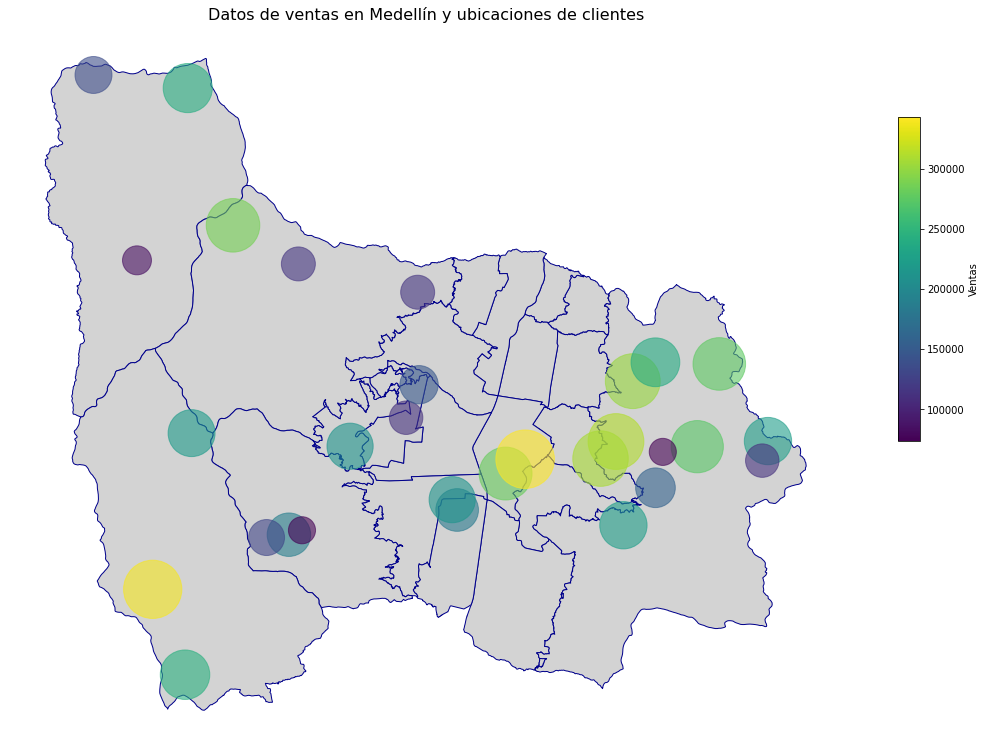

In [6]:
# Importar las librerías necesarias
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import FloatType
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

spark = SparkSession.builder.getOrCreate()

# Definir la ruta del archivo Parquet con datos de ventas en la capa Silver
cargue_inicial_path = 'hdfs:///user/root/silver/unificado.parquet'

try:
    # Cargar el archivo Parquet de cargue inicial como un DataFrame de Spark
    df_cargue = spark.read.parquet(cargue_inicial_path)

    # Convertir las columnas de longitud y latitud a tipo Float
    df_cargue = df_cargue.withColumn('longitude', col('longitude').cast(FloatType())) \
                         .withColumn('latitude', col('latitude').cast(FloatType()))

    # Convertir el DataFrame de Spark en un DataFrame de Pandas
    df_cargue_pd = df_cargue.toPandas()

    # Crear una columna de geometría en el DataFrame de Pandas
    df_cargue_pd['geom'] = df_cargue_pd.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

    # Convertir el DataFrame de Pandas en un GeoDataFrame de GeoPandas
    gdf_cargue = gpd.GeoDataFrame(df_cargue_pd, geometry='geom')
    
    # Cargar el archivo Parquet de geometrías de Medellín como un GeoDataFrame de GeoPandas
    medellin_neighborhoods = gpd.read_parquet('medellin_neighborhoods.parquet')

    # Crear una escala de colores basada en las ventas
    norm = mcolors.Normalize(vmin=gdf_cargue['sales'].min(), vmax=gdf_cargue['sales'].max())
    cmap = cm.ScalarMappable(norm=norm, cmap='viridis')

    # Asignar colores a cada punto basado en las ventas
    gdf_cargue['color'] = gdf_cargue['sales'].apply(lambda x: cmap.to_rgba(x))

    # Crear el gráfico con las geometrías de Medellín y los puntos del cargue inicial
    fig, ax = plt.subplots(figsize=(15, 15))
    medellin_neighborhoods.plot(ax=ax, color='lightgrey', edgecolor='darkblue')
    
    # Graficar los puntos con tamaño proporcional a las ventas y colores variados
    gdf_cargue.plot(ax=ax, color=gdf_cargue['color'], markersize=gdf_cargue['sales'] / 100, alpha=0.6)
    
    plt.title('Datos de ventas en Medellín y ubicaciones de clientes', fontsize = 16)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.grid(False)
    
    cax = fig.add_axes([0.95, 0.45, 0.02, 0.3])
    cbar = plt.colorbar(cmap, cax=cax, orientation='vertical', label='Ventas')
    
    # Guardar la figura en un archivo si la visualización es correcta
    plt.savefig('./medellin_neighborhoods_simulacion.png')
    plt.savefig('./medellin_neighborhoods_simulacion.jpg')
    plt.show()
    plt.close()
    
except Exception as e:
    print(f"Error al convertir o visualizar los datos con GeoPandas: {str(e)}")

## **Modelo Machine Learning**

In [10]:
# Datos en Spark
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import FloatType
from shapely.geometry import Point
import matplotlib.pyplot as plt
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

spark = SparkSession.builder.getOrCreate()

# Definir la ruta del archivo Parquet con datos de ventas en la capa Silver
cargue_inicial_path = 'hdfs:///user/root/silver/unificado.parquet'

# Cargar el archivo Parquet de cargue inicial como un DataFrame de Spark
df_cargue = spark.read.parquet(cargue_inicial_path)

# Convertir las columnas de longitud y latitud a tipo Float y crear columna 'geom'
df_cargue = df_cargue.withColumn('longitude', col('longitude').cast(FloatType())) \
                         .withColumn('latitude', col('latitude').cast(FloatType()))
# df_cargue.show()
df_cargue.columns

# Seleccionar las columnas necesarias
df_pronostico = df_cargue.select('latitude', 'longitude', 'sales')

# Mostrar el DataFrame
df_pronostico.show()

+---------+----------+------+
| latitude| longitude| sales|
+---------+----------+------+
|6.3197365| -75.67512|154000|
|  6.36707| -75.67735| 91000|
|6.3632092| -75.69386| 73500|
|6.2032857| -75.63984|336000|
| 6.225831| -75.68025|182000|
|6.1815095| -75.63611|178500|
|6.2283854| -75.68699|105000|
|6.2170324|-75.635666|108500|
| 6.254221| -75.51898| 70000|
|6.2457237|-75.543144|147000|
| 6.243882|  -75.5662|276500|
| 6.248552| -75.60412|308000|
|6.2446923| -75.60327|304500|
| 6.297997| -75.54851|171500|
| 6.186125| -75.67372|203000|
|6.2844853| -75.50904|322000|
|6.2447624|-75.521286|119000|
| 6.178686| -75.67137|157500|
|6.1749144| -75.65138| 70000|
|6.2074018|-75.492714|185500|
+---------+----------+------+



In [38]:
# # Seleccionar las características y la etiqueta
# feature_columns = ['latitude', 'longitude']
# assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
# data = assembler.transform(df_pronostico).select("features", col("sales").alias("label"))

# # Dividir los datos en entrenamiento y prueba
# train_data, test_data = data.randomSplit([0.7, 0.3], seed=1234)

# # Definir el modelo de Random Forest Regressor
# rf = RandomForestRegressor(featuresCol="features", labelCol="label", numTrees=100)

# # Entrenar el modelo
# model = rf.fit(train_data)

# # Hacer predicciones
# predictions = model.transform(test_data)

# # Evaluar el modelo
# evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
# rmse = evaluator.evaluate(predictions)
# print(f"Root Mean Squared Error (RMSE) en el conjunto de prueba: {rmse}")

# # Mostrar las predicciones
# predictions.select("prediction", "label", "features").show()

# Seleccionar las características y la etiqueta
feature_columns = ['latitude', 'longitude']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(df_pronostico).select("features", col("sales").alias("label"))

# Dividir los datos en entrenamiento y prueba
train_data, test_data = data.randomSplit([0.7, 0.3], seed=1234)

# Definir el modelo de Random Forest Regressor
rf = RandomForestRegressor(featuresCol="features", labelCol="label", numTrees=100)

# Entrenar el modelo
model = rf.fit(train_data)

# Hacer predicciones
predictions = model.transform(test_data)

# Evaluar el modelo
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) en el conjunto de prueba: {rmse}")

# Mostrar las predicciones
predictions.select("prediction", "label", "features").show()

# Unir las predicciones con las coordenadas originales para mostrar los pronósticos por lugar
predictions_with_coords = predictions.join(df_pronostico, on=['latitude', 'longitude'], how='inner')
predictions_with_coords.select("latitude", "longitude", "prediction", "sales").show()

Root Mean Squared Error (RMSE) en el conjunto de prueba: 117044.3582940669
+------------------+------+--------------------+
|        prediction| label|            features|
+------------------+------+--------------------+
|185441.08333333337| 70000|[6.17491436004638...|
|187185.25000000003|157500|[6.17868614196777...|
| 172017.4166666667|336000|[6.20328569412231...|
+------------------+------+--------------------+



AnalysisException: USING column `latitude` cannot be resolved on the left side of the join. The left-side columns: [features, label, prediction]

In [ ]:
# Gráfico Final
# Definir la ruta del archivo Parquet con datos de ventas en la capa Silver
cargue_inicial_path = 'hdfs:///user/root/silver/unificado.parquet'

try:
    # Cargar el archivo Parquet de cargue inicial como un DataFrame de Spark
    df_cargue = spark.read.parquet(cargue_inicial_path)#.limit(10)  # Limitar a 10 registros para pruebas

    # Convertir las columnas de longitud y latitud a tipo Float
    df_cargue = df_cargue.withColumn('longitude', col('longitude').cast(FloatType())) \
                         .withColumn('latitude', col('latitude').cast(FloatType()))
    df_cargue.show()

    # Convertir el DataFrame de Spark en un DataFrame de Pandas
    df_cargue_pd = df_cargue.toPandas()

    # Crear una columna de geometría en el DataFrame de Pandas
    df_cargue_pd['geom'] = df_cargue_pd.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

    # Convertir el DataFrame de Pandas en un GeoDataFrame de GeoPandas
    gdf_cargue = gpd.GeoDataFrame(df_cargue_pd, geometry='geom')

    # Imprimir las primeras filas para verificar la conversión
    print("Primeras filas de GeoDataFrame:")
    print(gdf_cargue.head())

    # Definir la ruta del archivo Parquet con geometrías de Medellín en la capa Bronze
    medellin_neighborhoods_path = 'medellin_neighborhoods.parquet'

    # Cargar el archivo Parquet de geometrías de Medellín como un GeoDataFrame de GeoPandas
    medellin_neighborhoods = gpd.read_parquet(medellin_neighborhoods_path)

    # Imprimir las primeras filas para verificar la carga de datos
    print("\nPrimeras filas de medellin_neighborhoods GeoDataFrame:")
    print(medellin_neighborhoods.head())

    # Crear el gráfico con las geometrías de Medellín y los puntos del cargue inicial
    fig, ax = plt.subplots(figsize=(10, 10))
    medellin_neighborhoods.plot(ax=ax, color='lightgrey', edgecolor='darkblue')
    gdf_cargue.plot(ax=ax, color='blue', markersize=50, alpha=0.6)

    plt.title('Datos simulados de ventas en Medellín y ubicaciones de clientes')
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')
    plt.grid(True)
    plt.show()
    
    # Guardar la figura en un archivo si la visualización es correcta
    plt.savefig('./medellin_neighborhoods_simulacion.png')
    plt.close()
    
except Exception as e:
    print(f"Error al convertir o visualizar los datos con GeoPandas: {str(e)}")
